In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [16]:
import pandas as pd
import seaborn as sns

sns.set_theme(context='talk', 
              style='whitegrid', 
              palette='Set2',
              font_scale=1.4, 
              rc={'figure.figsize': (14, 6)})

import plotly.graph_objects as go
import plotly.io as pio
import plotly.express as px
import plotly
pio.templates.default = 'plotly_white+presentation'



import scipy.constants as sc

hbarc = sc.hbar*sc.speed_of_light/sc.giga/sc.electron_volt / sc.femto

import json
import os
import glob

import sys
sys.path.append('../src')
from luscher_lib import Luscher_zeta, Kcot_luscher

from tqdm import tqdm

# load data

In [7]:
df_conf = pd.read_csv('../data/CLS_conf_inf.csv')
df_conf['a2 [fm2]'] = df_conf['a [fm]'].apply(lambda x: x**2)
df_conf['a_inv [GeV]'] = (hbarc / df_conf['a [fm]']).round(3) # add lattice unit
df_conf

Label  N_f  beta     kappa  size_L  size_T bdy.cond.  a [fm]  m_pi [MeV]  \
0  N300    3  3.70  0.137000      48     128      open  0.0498         422   
1  N202    3  3.55  0.137000      48     128      open  0.0642         412   
2  H200    3  3.55  0.137000      32      96      open  0.0642         419   
3  B450    3  3.46  0.136890      32      64  periodic  0.0762         417   
4  H101    3  3.40  0.136760      32      96      open  0.0865         417   
5  U103    3  3.40  0.136760      24     128      open  0.0865         414   
6  A653    3  3.34  0.136572      24      48  periodic  0.0992         424   
7    E5    2  5.30  0.136250      32      64  periodic  0.0658         436   
8    E1    2  5.30  0.135500      32      64  periodic  0.0658         978   

   L [fm]  m_pi L  m_B [GeV]  N_conf  N_tsrc  N_meas  N_LapH  a2 [fm2]  \
0     2.4     5.1       1.19    2047      12   24564      32  0.002480   
1     3.1     6.4       1.17     899       8   10788      68  0.004122   
2     2.1     4.4       1.19    2000       8   16000      20  0.004122   
3     2.4     5.2       1.18    1612       8   25762      32  0.005806   
4     2.8     5.9       1.16    2016       4   12096      48  0.007482   
5     2.1     4.4       1.18    5658       5   45264      20  0.007482   
6     2.4     5.1       1.16    5050       4   40400      32  0.009841   
7     2.1     4.7       1.29    2000       4   16000      30  0.004330   
8     2.1    10.4       2.03     168       8    2688      30  0.004330   

   a_inv [GeV]  
0        3.962  
1        3.074  
2        3.074  
3        2.590  
4        2.281  
5        2.281  
6        1.989  
7        2.999  
8        2.999

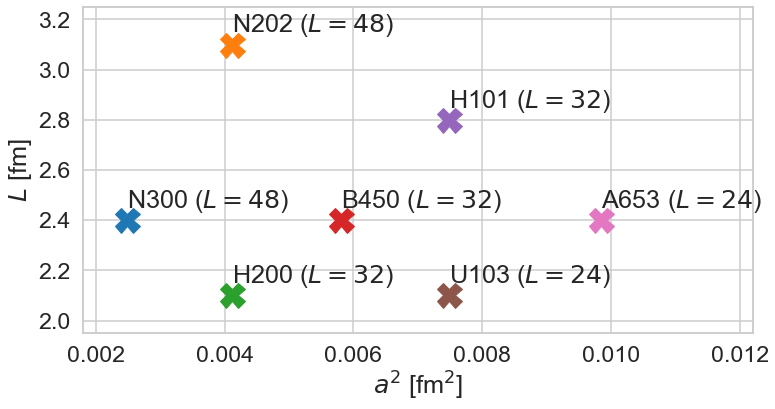

In [8]:
# for utility
lat_unit_dic = df_conf.set_index('Label')['a [fm]'].to_dict()
a_inv_dic = df_conf.set_index('Label')['a_inv [GeV]'].to_dict()
L_fm_dic = df_conf.set_index('Label')['L [fm]'].to_dict()
L_dic = df_conf.set_index('Label')['size_L'].to_dict()
pion_mass_dic = df_conf.set_index('Label')['m_pi [MeV]'].to_dict()
baryon_mass_dic = df_conf.set_index('Label')['m_B [GeV]'].to_dict()
label_list = list(df_conf['Label'])

with sns.color_palette('tab10'):
    fig, ax = plt.subplots(figsize=(12, 6))
    for label in label_list:
        if label in ['E5', 'E1']: continue
        a2 = lat_unit_dic.get(label)**2
        L_fm = L_fm_dic.get(label)
        ax.plot(a2, L_fm, 'X', ms=25)
        ax.text(a2, L_fm+0.05, fr'{label} ($L = {L_dic.get(label)}$)')
    ax.set(xlabel=r'$a^2$ [fm$^2$]', ylabel='$L$ [fm]', xlim=(0.0018, 0.0122), ylim=(1.95, 3.25))
#    fig.savefig('../figs/SU3_ensembles.png', bbox_inches='tight')

In [10]:
ls ../data/pcot_p2/

A653_P000_0_spin_zero.json  H101_P011_0_spin_zero.json
A653_P000_1_spin_zero.json  H101_P011_1_spin_zero.json
A653_P001_0_spin_zero.json  H101_P111_0_spin_zero.json
A653_P001_1_spin_zero.json  H101_P111_1_spin_zero.json
A653_P002_0_spin_zero.json  H200_P000_0_spin_zero.json
A653_P011_0_spin_zero.json  H200_P000_1_spin_zero.json
A653_P011_1_spin_zero.json  H200_P001_0_spin_zero.json
A653_P111_0_spin_zero.json  H200_P001_1_spin_zero.json
A653_P111_1_spin_zero.json  H200_P002_0_spin_zero.json
B450_P000_0_spin_zero.json  H200_P011_0_spin_zero.json
B450_P000_1_spin_zero.json  H200_P011_1_spin_zero.json
B450_P001_0_spin_zero.json  H200_P111_0_spin_zero.json
B450_P001_1_spin_zero.json  H200_P111_1_spin_zero.json
B450_P002_0_spin_zero.json  N202_P000_0_spin_zero.json
B450_P011_0_spin_zero.json  N202_P000_1_spin_zero.json
B450_P011_1_spin_zero.json  N202_P001_0_spin_zero.json
B450_P111_0_spin_zero.json  N202_P001_1_spin_zero.json
B450_P111_1_spin_zero.json  N202_P002_0_spin_zero.json
E1_P000_0_

In [18]:
ld_dic = {}
for fname in glob.glob('../data/pcot_p2/*.json'):
    with open(fname, 'r') as fin:
        tmp = json.load(fin)
        ld_dic[(tmp.get('label'), tmp.get('frame'), tmp.get('level'))] = tmp

# plot

In [19]:
xlim0 = (-0.8, 2.5)
ylim0 = (-0.9, 4.9)


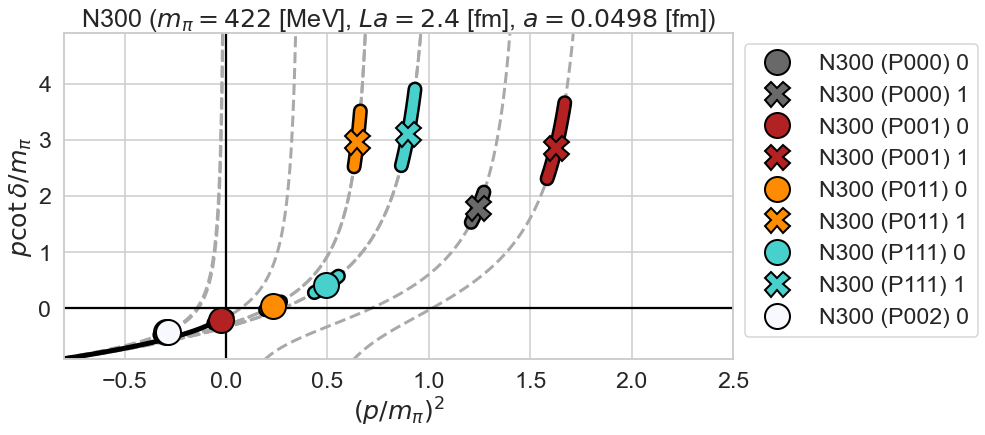

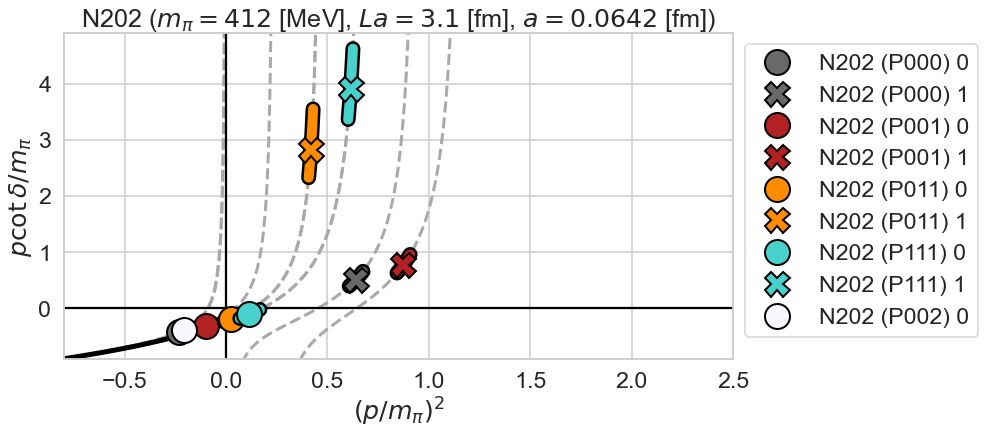

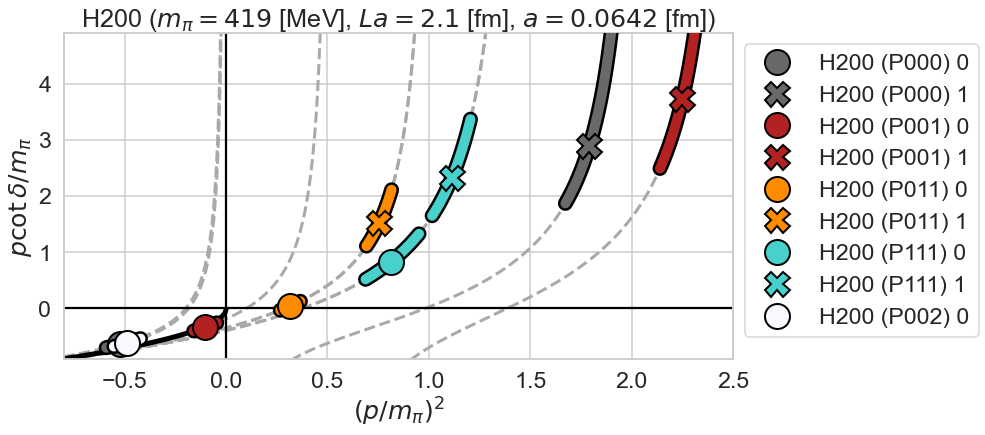

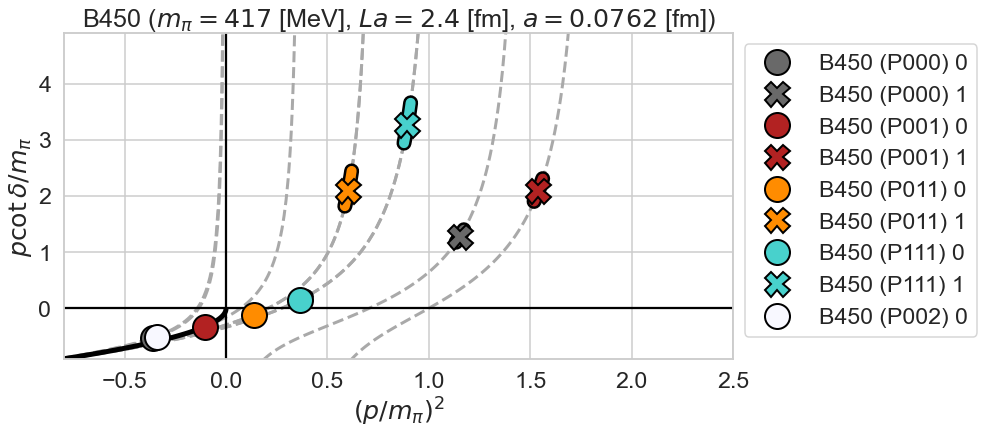

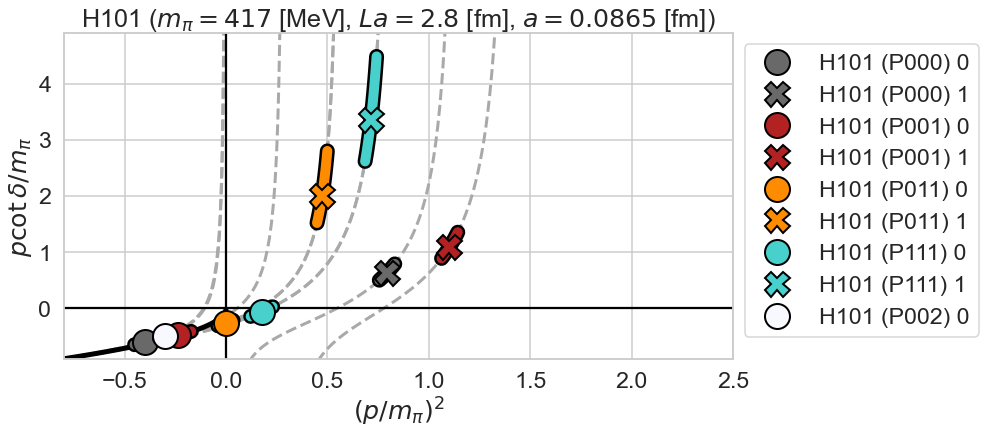

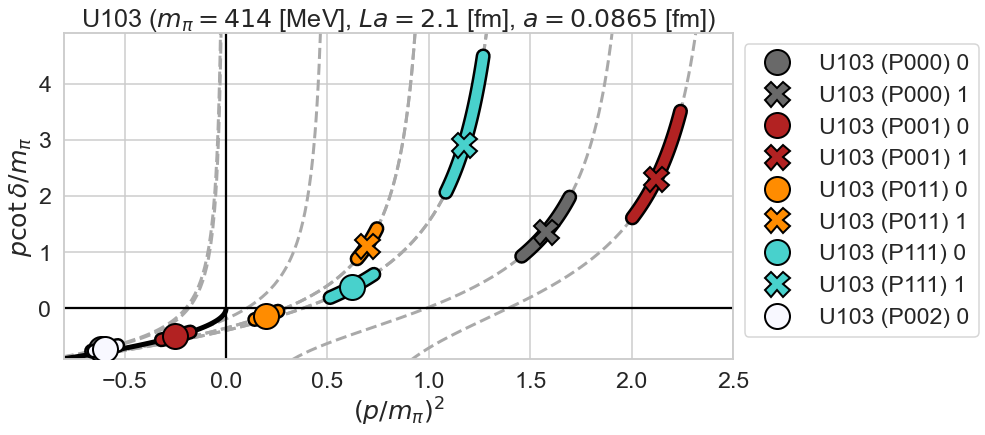

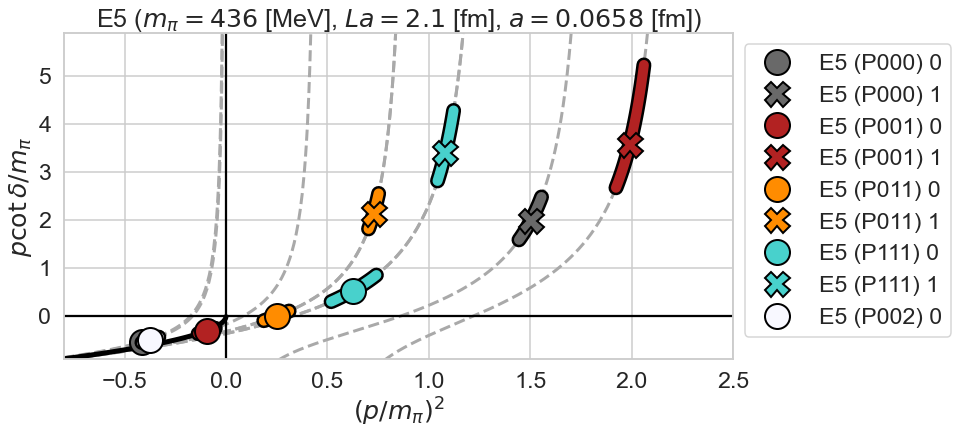

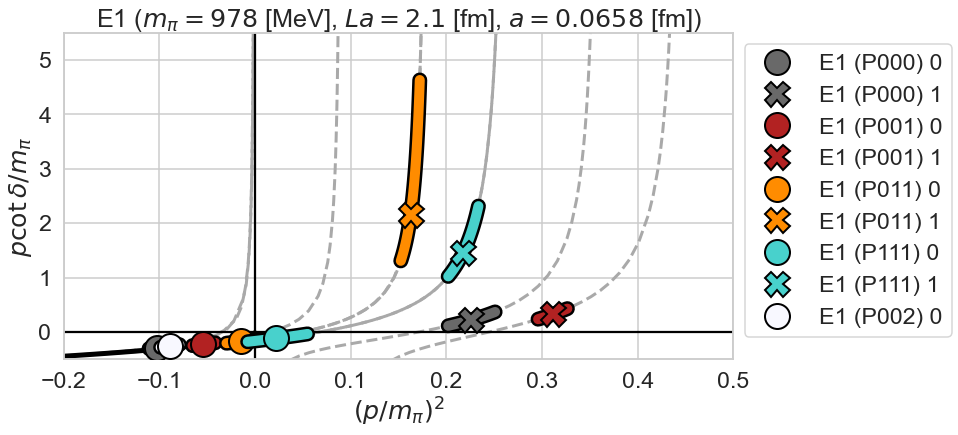

In [35]:
xlim, ylim = xlim0, ylim0

color_list = {'P000': 'dimgray', 'P001': 'firebrick', 'P011': 'darkorange', 'P111': 'mediumturquoise', 'P002': 'ghostwhite'}

for label in ['N300', 'N202', 'H200', 'B450', 'H101', 'U103', 'A653', 'E5', 'E1']:
    if label == 'E1':
        xlim, ylim = (-0.2, 0.5), (-0.5, 5.5)
    if label == 'E5':
        xlim, ylim = (-0.8, 2.5), (-0.9, 5.9)
        
    fig, ax = plt.subplots(figsize=(12, 6))

    for frame in ['P000', 'P001', 'P011', 'P111', 'P002']:
        c = color_list.get(frame)
        for level in [0, 1]:
            try:
                ld = ld_dic[(label, frame, level)]

                ax.plot(ld.get('k2mpi2s'), ld.get('kcot_mpis'), color='black', zorder=3, lw=15)
                ax.plot(ld.get('k2mpi2s'), ld.get('kcot_mpis'), color=c, zorder=3, lw=10)

                sym = {0: 'o', 1: 'X'}[level]
                ax.plot(ld.get('k2mpi2'), ld.get('kcot_mpi'), sym, ms=25, color=c, mec='black', mew=2, zorder=3, label=f'{label} ({frame}) {level}')
                ax.plot(ld.get('k2mpi2_ref'), ld.get('kcot_mpi_ref'), ls='--', lw=3, color='darkgray')


            except:
                pass
            
    xbs = np.concatenate([np.linspace(xlim0[0], -0.5e-1), np.linspace(-0.5e-1, -2e-4)])
    ax.plot(xbs, - np.sqrt(-xbs), color='black', ls='-', lw=5)

    ax.legend(loc='upper left', bbox_to_anchor=(1,1))
    ax.axhline(0, color='black')
    ax.axvline(0, color='black')
    ax.set(ylim=ylim, xlim=xlim, xlabel=r'$(p/m_\pi)^2$', ylabel=r'$p\cot\delta/m_\pi$',
          title=rf'{label} ($m_\pi = {pion_mass_dic.get(label)}$ [MeV], $La = {L_fm_dic.get(label)}$ [fm], $a = {lat_unit_dic.get(label)}$ [fm])')
    fig.savefig(f'../figs/pcot_vs_p2/{label}_pcot_vs_p2.png', bbox_inches='tight') # , transparent=True)

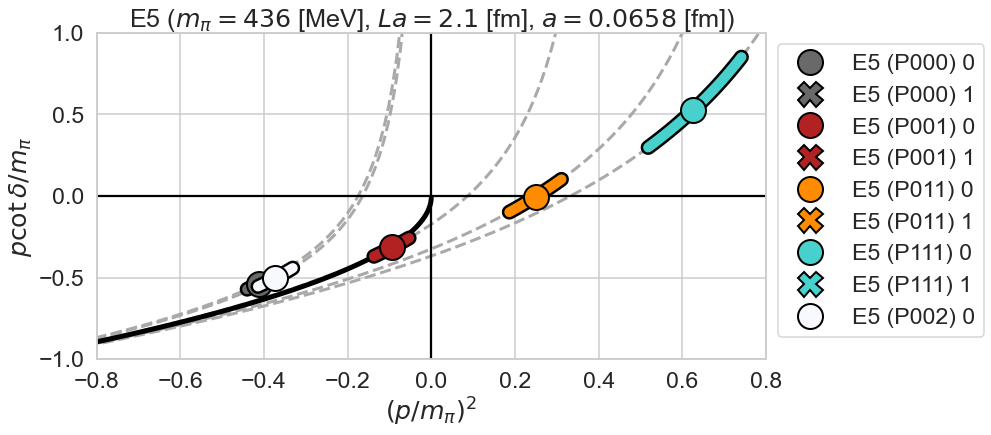

In [46]:
xlim, ylim = (-0.8, 0.4), (-0.9, 0.4)

color_list = {'P000': 'dimgray', 'P001': 'firebrick', 'P011': 'darkorange', 'P111': 'mediumturquoise', 'P002': 'ghostwhite'}

for label in ['N300', 'N202', 'H200', 'B450', 'H101', 'U103', 'A653', 'E5', 'E1']:
    if label == 'E1':
        xlim, ylim = (-0.2, 0.1), (-0.5, 0.1)
    elif label == 'E5':
        xlim, ylim = (-0.8, 0.8), (-1, 1)
    else:
        continue

    
    fig, ax = plt.subplots(figsize=(12,6))

    for frame in ['P000', 'P001', 'P011', 'P111', 'P002']:
        c = color_list.get(frame)
        for level in [0, 1]:
            try:
                ld = ld_dic[(label, frame, level)]

                ax.plot(ld.get('k2mpi2s'), ld.get('kcot_mpis'), color='black', zorder=3, lw=15)
                ax.plot(ld.get('k2mpi2s'), ld.get('kcot_mpis'), color=c, zorder=3, lw=10)

                sym = {0: 'o', 1: 'X'}[level]
                ax.plot(ld.get('k2mpi2'), ld.get('kcot_mpi'), sym, ms=25, color=c, mec='black', mew=2, zorder=3, label=f'{label} ({frame}) {level}')
                if level == 0:
                    ax.plot(ld.get('k2mpi2_ref'), ld.get('kcot_mpi_ref'), ls='--', lw=3, color='darkgray')


            except:
                pass
            
    xbs = np.concatenate([np.linspace(xlim0[0], -0.5e-1), np.linspace(-0.5e-1, -2e-4)])
    ax.plot(xbs, - np.sqrt(-xbs), color='black', ls='-', lw=5)

    ax.legend(loc='upper left', bbox_to_anchor=(1,1))
    ax.axhline(0, color='black')
    ax.axvline(0, color='black')
    ax.set(ylim=ylim, xlim=xlim, xlabel=r'$(p/m_\pi)^2$', ylabel=r'$p\cot\delta/m_\pi$',
          title=rf'{label} ($m_\pi = {pion_mass_dic.get(label)}$ [MeV], $La = {L_fm_dic.get(label)}$ [fm], $a = {lat_unit_dic.get(label)}$ [fm])')
    fig.savefig(f'../figs/pcot_vs_p2/{label}_pcot_vs_p2_neg.png', bbox_inches='tight') # , transparent=True)

In [24]:
def plotly_pcot_vs_p2(label, xlim, ylim):
    fig = go.Figure()

    color_list = {'P000': 'dimgray', 'P001': 'firebrick', 'P011': 'darkorange', 'P111': 'mediumturquoise', 'P002': 'ghostwhite'}


    xbs = np.concatenate([np.linspace(xlim[0], -0.5e-1), np.linspace(-0.5e-1,-2e-4)])


    fig.add_hline(y=0, line_width=3)
    fig.add_vline(x=0, line_width=3)

    fig.add_trace(
        go.Scatter(x=xbs, y=-np.sqrt(-xbs), mode='lines',
                  line=dict(color='black', width=5), name='bound state condition', showlegend=False)
    )


    for frame in ['P000', 'P001', 'P011', 'P111' ,'P002']:
        c = color_list.get(frame)
        for level in [0, 1]:
            try:
                ld = ld_dic[(label, frame, level)]

                sym={0:'circle', 1:'x', 2:'triangle-up'}[level]

                lbl = f'{label} ({frame}) n={level}'

                if (level == 1) and (frame in ['P011', 'P111']):
                    pass
                else:
                    fig.add_traces(
                        [
                            go.Scatter(x=ld.get('k2mpi2_ref'), y=ld.get('kcot_mpi_ref'), mode='lines',
                                        line=dict(dash='dash', color='gray', width=2), legendgroup=lbl, name='FV constraints', showlegend=False,
                                       hovertemplate='(%{x:.3f}, %{y:.3f})'
                                      )])
                fig.add_traces(
                    [
                        go.Scatter(x=ld.get('k2mpi2s'), y=ld.get('kcot_mpis'), mode='lines',
                                  line=dict(color='black', width=12), legendgroup=lbl, name='95CI',
                                  hovertemplate='(%{x:.3f}, %{y:.3f})', showlegend=False),
                        go.Scatter(x=ld.get('k2mpi2s'), y=ld.get('kcot_mpis'), mode='lines',
                                  line=dict(color=c, width=8), legendgroup=lbl, name='95CI',
                                  hovertemplate='(%{x:.3f}, %{y:.3f})', showlegend=False),
                        go.Scatter(x=[ld.get('k2mpi2')], y=[ld.get('kcot_mpi')], mode='markers',
                                   hovertemplate=lbl+'<br>(%{x:.3f}, %{y:.3f})', showlegend=True,
                                    marker=dict(color=c, size=25, symbol=sym,
                                               line=dict(width=2, color='black')), legendgroup=lbl, name=lbl)
                    ]
                )
            except:
                pass #print(label, frame, level)



    fig.update_layout(
        title=f'$\LARGE{{\mathrm{{{label}}} \ (m_\pi = {pion_mass_dic.get(label)} \ [\mathrm{{MeV}}], \ La = {L_fm_dic.get(label)} \ [\mathrm{{fm}}], a = {lat_unit_dic.get(label)} \ [\mathrm{{fm}}])}}$',
        xaxis_title='$\LARGE{(p/m_\pi)^2}$', 
                     yaxis_title='$\LARGE{p\cot\delta/m_\pi}$',
                     xaxis_range=xlim, yaxis_range=ylim,
                     font=dict(size=32))
    fig.write_html(f'../figs/pcot_vs_p2/{label}_pcot_vs_p2.html', include_mathjax='cdn', include_plotlyjs='cdn')
    return fig

In [25]:
label_list

['N300', 'N202', 'H200', 'B450', 'H101', 'U103', 'A653', 'E5', 'E1']

In [26]:
plotly_pcot_vs_p2('N300', xlim0, ylim0)

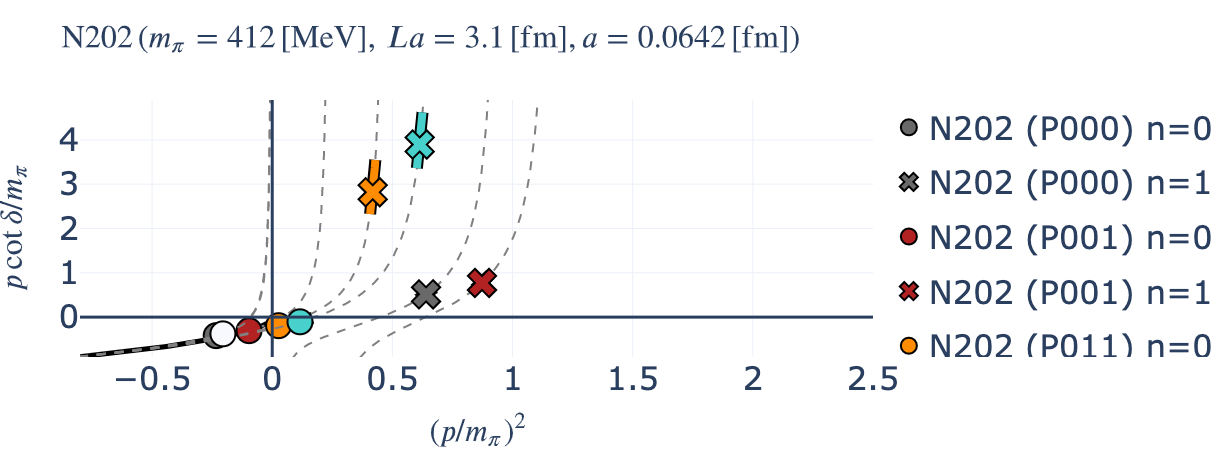

In [27]:
plotly_pcot_vs_p2('N202', xlim0, ylim0)

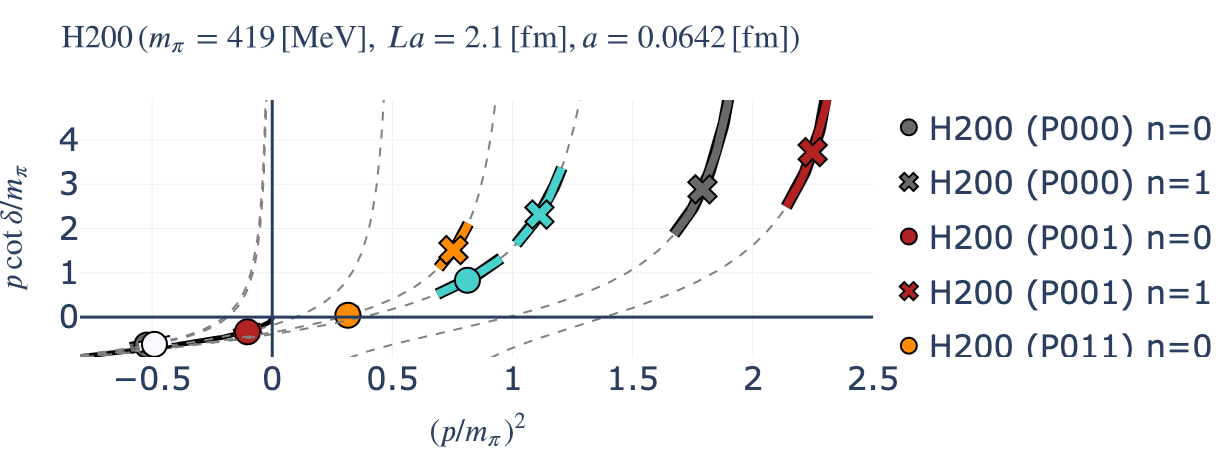

In [28]:
plotly_pcot_vs_p2('H200', xlim0, ylim0)

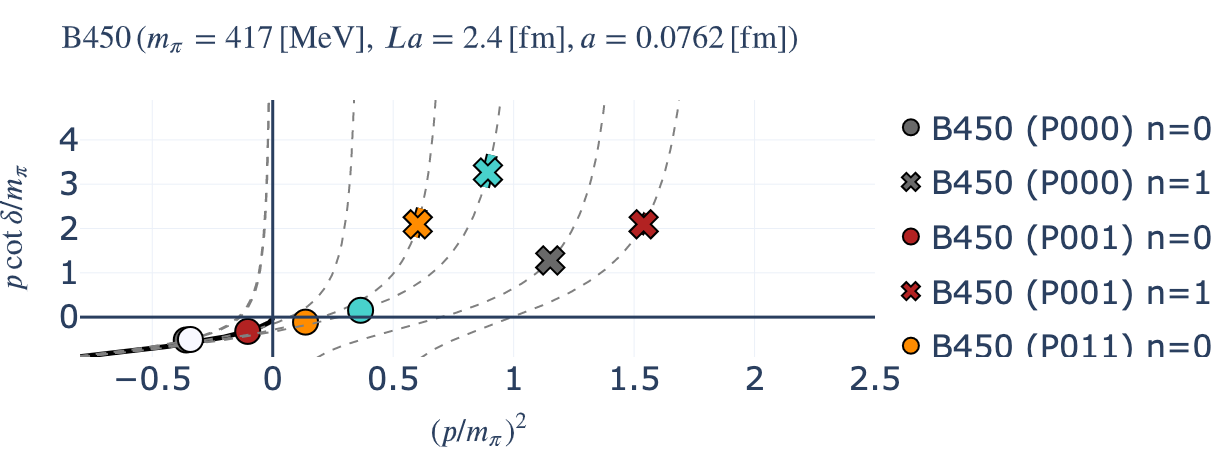

In [29]:
plotly_pcot_vs_p2('B450', xlim0, ylim0)

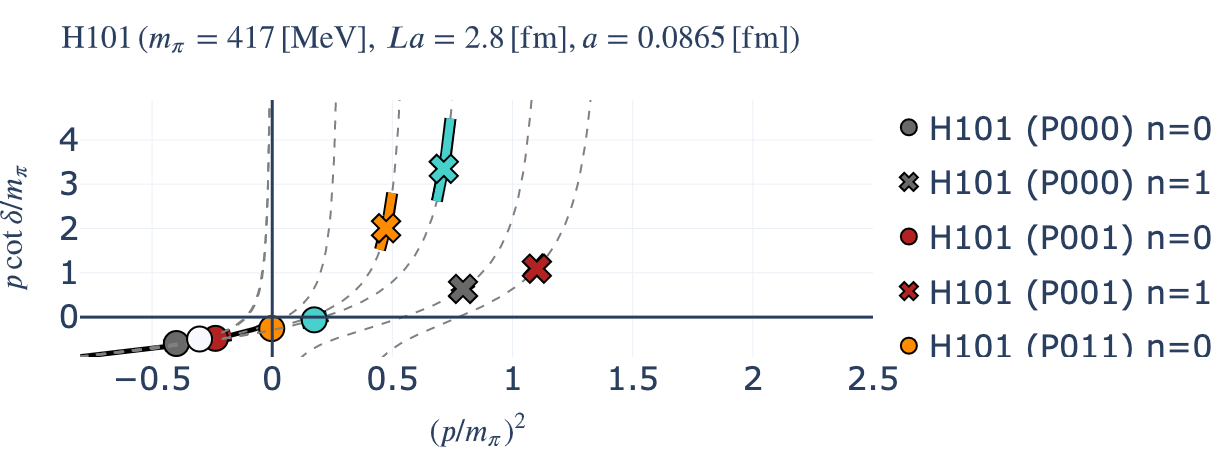

In [30]:
plotly_pcot_vs_p2('H101', xlim0, ylim0)

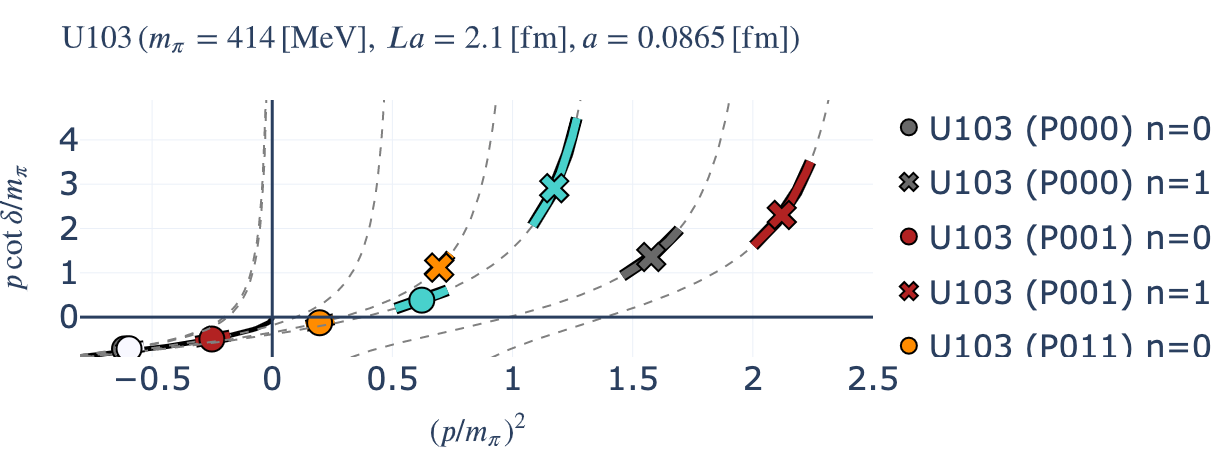

In [31]:
plotly_pcot_vs_p2('U103', xlim0, ylim0)

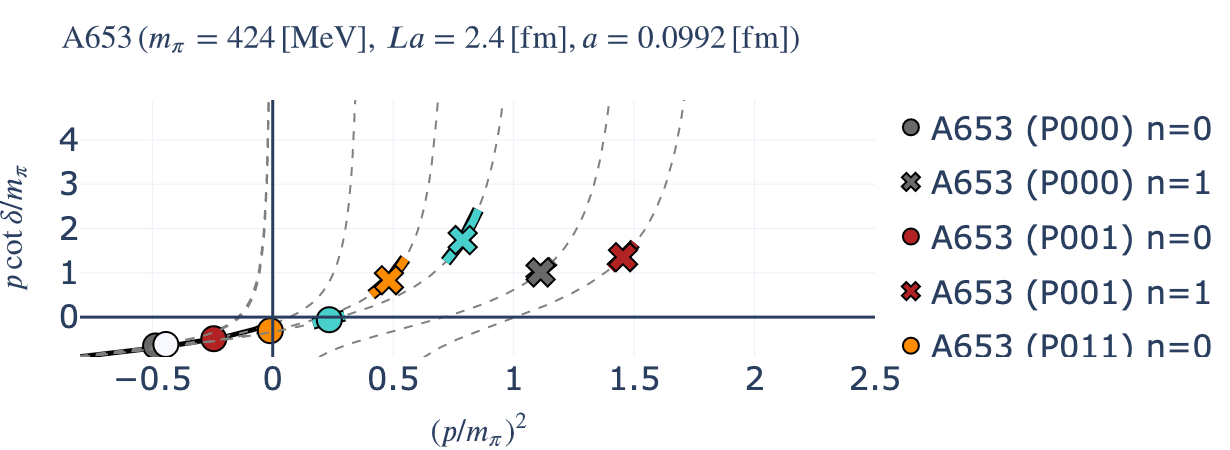

In [32]:
plotly_pcot_vs_p2('A653', xlim0, ylim0)

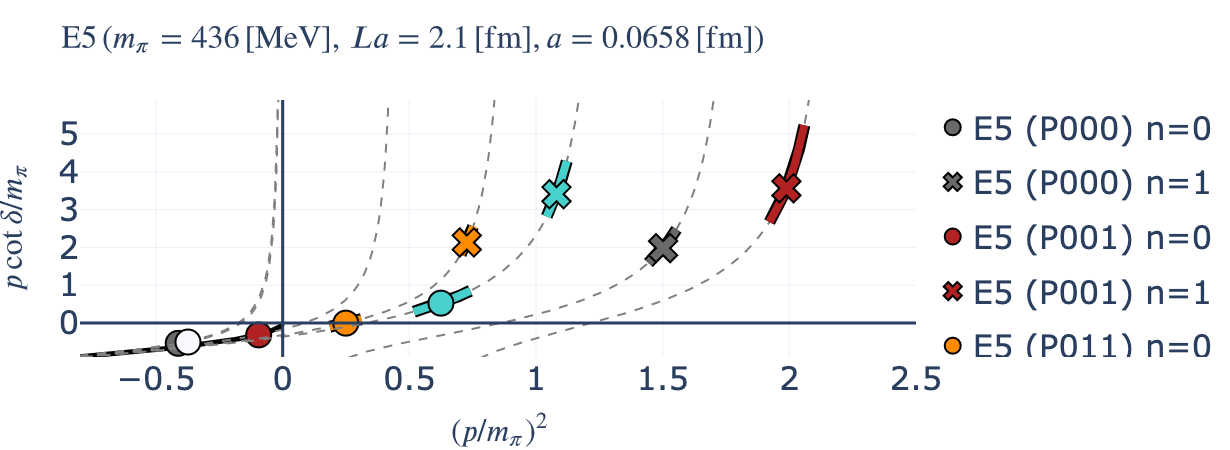

In [33]:
plotly_pcot_vs_p2('E5', (-0.8, 2.5), (-0.9, 5.9))

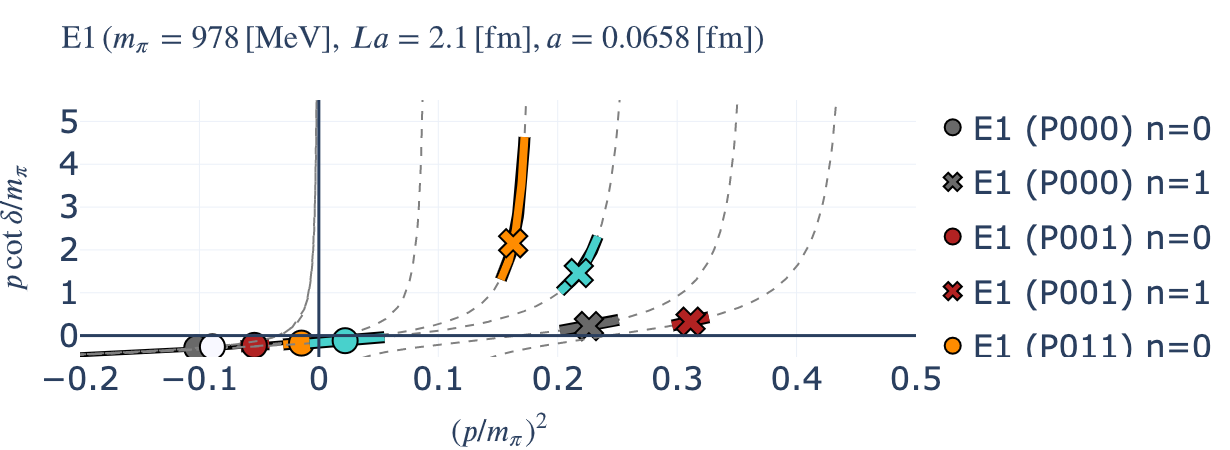

In [34]:
plotly_pcot_vs_p2('E1', (-0.2, 0.5), (-0.5, 5.5))